In [1]:
import json
import pickle
import sys
import os

# hack so we can import normally from other packages
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import torch

In [2]:
# PROJ_PATH = "/sciclone/proj-ds/geograd/stmorse/mdp"
PROJ_PATH = "/home/stmorse/data/mdp"

# single

In [66]:
exp_path = "fender/spreads_t_0.1_v0_0.2"
with open(os.path.join(PROJ_PATH, exp_path, "results.pkl"), "rb") as f:
    results = pickle.load(f)

with open(f"../scenarios/fender.json", "r") as f:
    scenario = json.load(f)

levers = scenario["levers"]

In [67]:
entail_embeddings = []
entail_probs = []
semantic_embeddings = []
texts = []
agents = []

K = len(levers)
L = len(results[levers[0]]) 
M = len(results[levers[0]][0])

for lever in levers:
    for rline in results[lever]:
        for response in rline:
            entail_embeddings.append(response["entail"][0])
            entail_probs.append(response["entail"][1])
            semantic_embeddings.append(response["semantic"])
            texts.append(response["response"])
            agents.append(response["agent"])

entail_embeddings = torch.stack(entail_embeddings).numpy()
entail_probs = torch.stack(entail_probs).numpy()
semantic_embeddings = np.vstack(semantic_embeddings)
agents = np.array(agents)

print(f"Levers: {K}, A1 per lever: {L}, Generations per A1 (incl A1): {M}")
print(entail_embeddings.shape, entail_probs.shape, semantic_embeddings.shape)

Levers: 5, A1 per lever: 5, Generations per A1 (incl A1): 21
(525, 1024) (525, 3) (525, 384)


In [68]:
epca = PCA(n_components=100).fit_transform(entail_embeddings)
spca = PCA(n_components=100).fit_transform(semantic_embeddings)

etsne = TSNE(n_components=2).fit_transform(epca)
stsne = TSNE(n_components=2).fit_transform(spca)

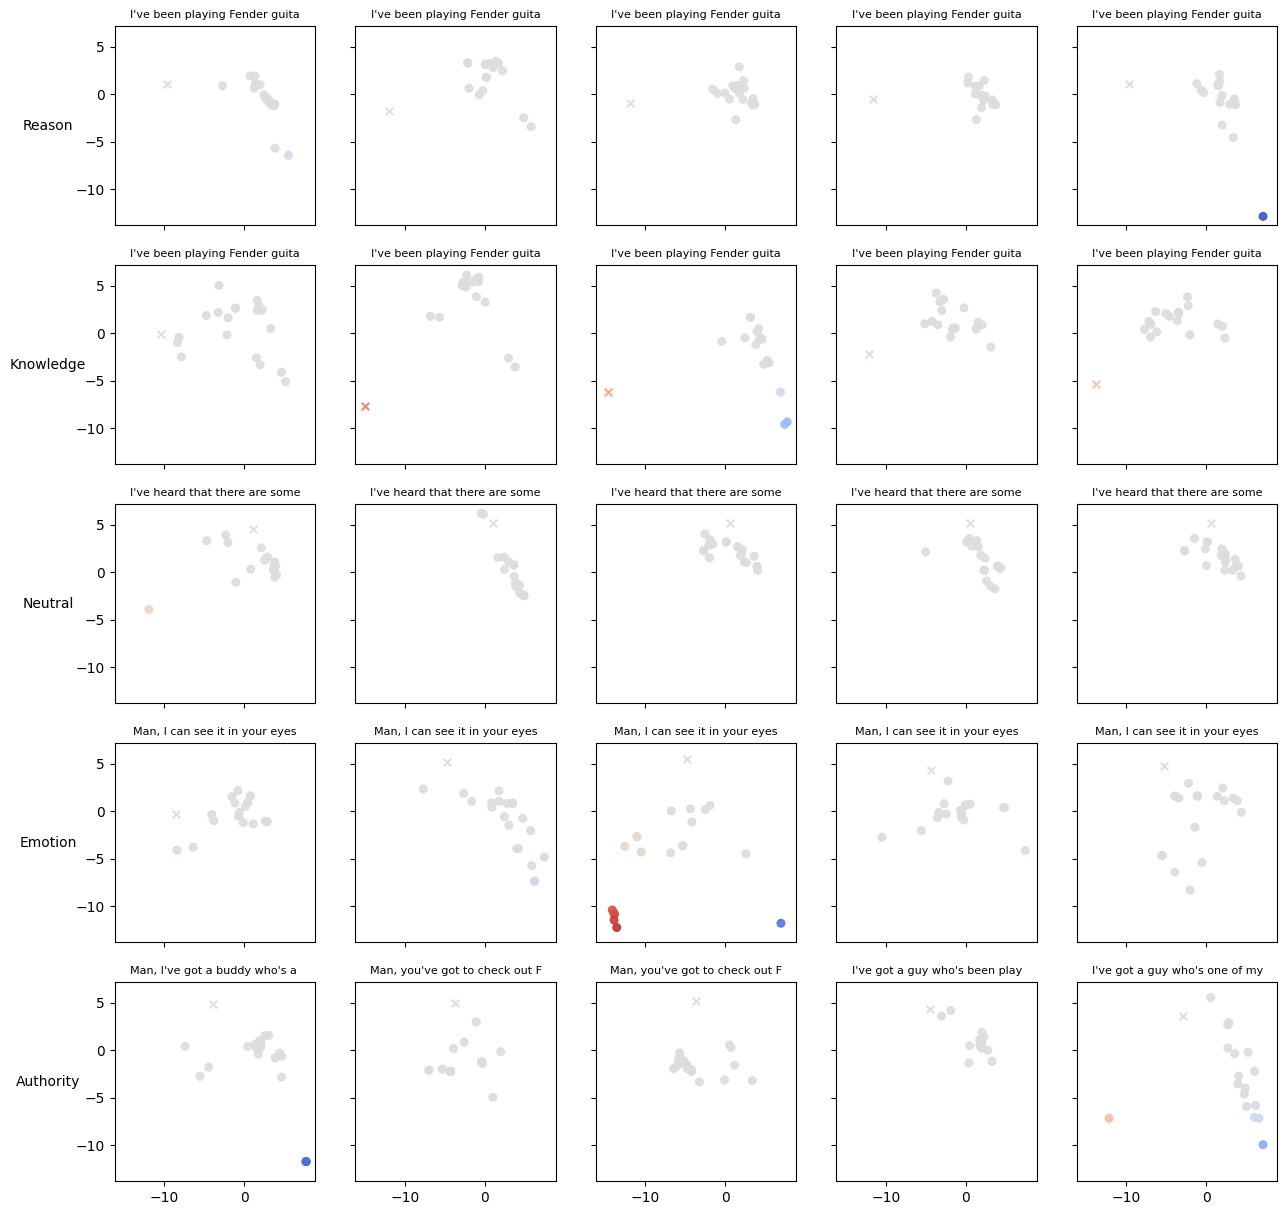

In [69]:
fig, axs = plt.subplots(K, L, figsize=(15,15), sharey=True, sharex=True)

norm = Normalize(vmin=-1, vmax=1)

lever_labels = ["Reason", "Knowledge", "Neutral", "Emotion", "Authority"]

# mr = etsne.reshape(K, L, M, -1)
mr = epca.reshape(K, L, M, -1)
pr = entail_probs.reshape(K, L, M, -1)
ix = np.arange(len(texts)).reshape(K, L, M)

for i in range(K):  # levers
    for j in range(L):  # agent 1 response
        ax = axs[i,j]

        # agent 1
        ax.scatter(mr[i, j, 0, 0], mr[i, j, 0, 1], 
            s=30, c=pr[i,j,0,0]-pr[i,j,0,2], cmap="coolwarm", norm=norm, marker="x", alpha=0.9)

        # # agent 0
        ax.scatter(mr[i, j, 1:, 0], mr[i, j, 1:, 1], 
            s=30, c=pr[i,j,1:,0]-pr[i,j,1:,2], cmap="coolwarm", norm=norm, marker="o", alpha=0.9)

        ax.set_title(texts[ix[i,j,0]][:30], fontsize=8)

    axs[i,0].set_ylabel(lever_labels[i], rotation=0, labelpad=20, va="center")
    axs[i,0].yaxis.label.set_wrap(True)

plt.show()

In [70]:
tx = np.where(entail_probs[:,2] > 0.5)[0]
for i in tx:
    print(f"({i}) ({entail_probs[i,2]:.3f}) {texts[i][:100]}")

(102) (0.954) I've had a few Fenders before, but I've always found them to be a bit too... predictable for my tast
(358) (0.819) I appreciate the enthusiasm, Rob, but I'm not sure I'm ready to jump on the Fender bandwagon just ye
(424) (0.857) I've heard of those Fender Strats before, they're definitely iconic, but I'm not sure if I'd want to
(436) (0.857) I've heard of those Fender Strats before, they're definitely iconic, but I'm not sure if I'd want to
(437) (0.857) I've heard of those Fender Strats before, they're definitely iconic, but I'm not sure if I'd want to
(515) (0.524) I've heard of John Mayer's endorsement of Fender before, but I'm not sure if it's enough for me to j


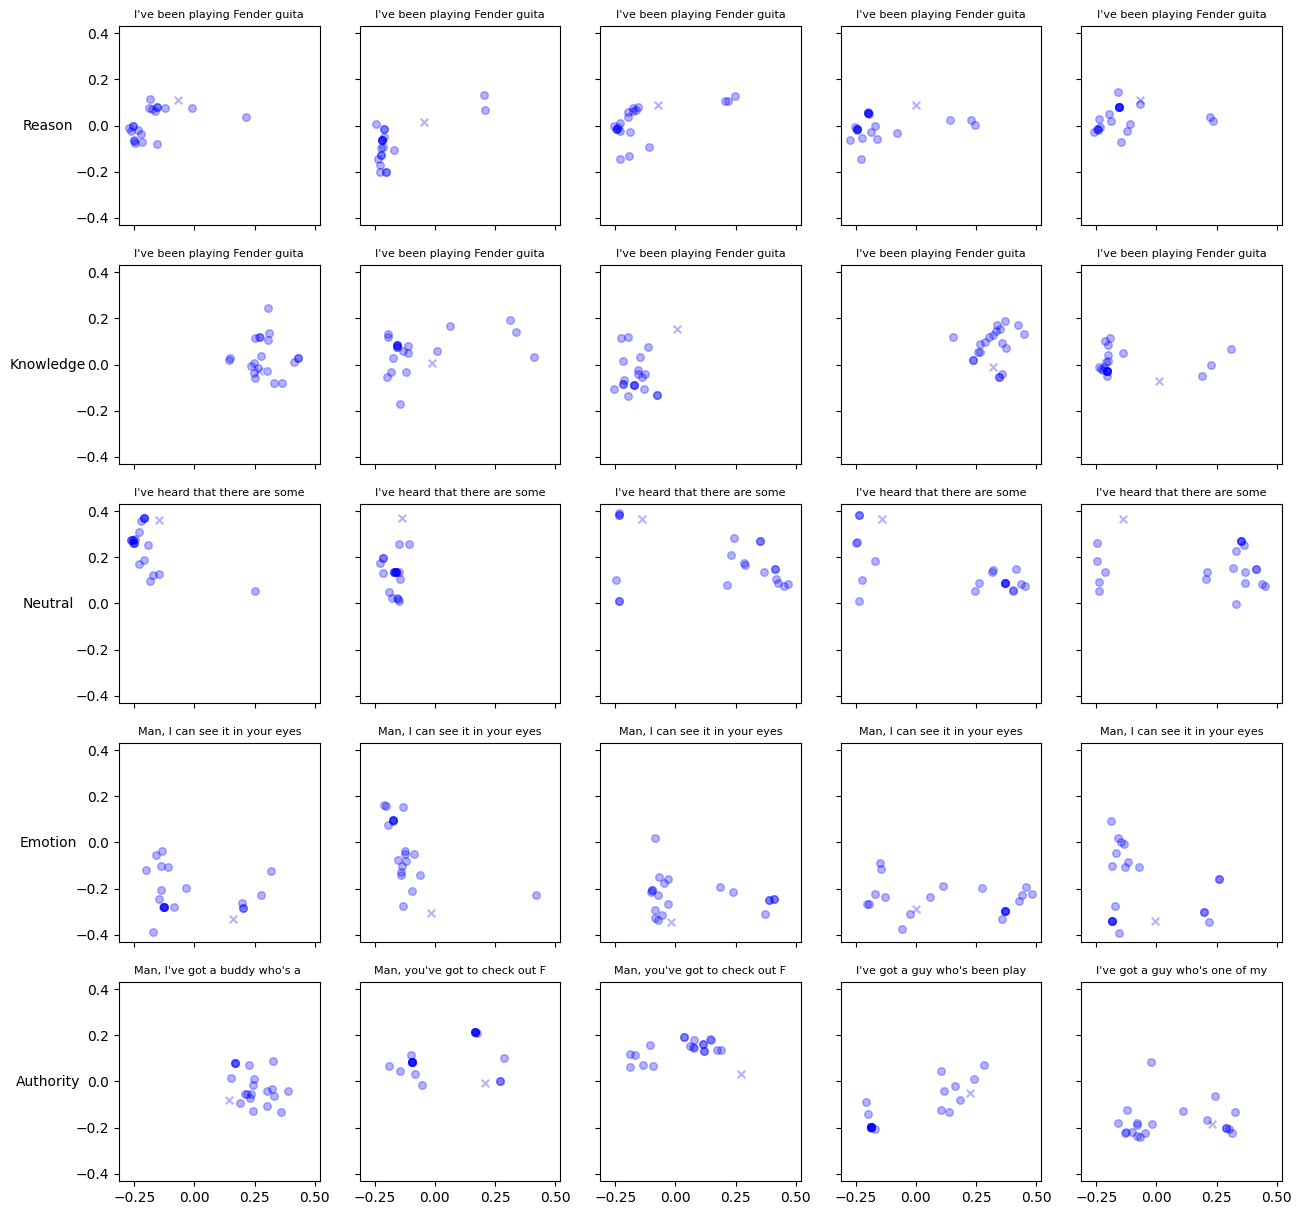

In [71]:
fig, axs = plt.subplots(K, L, figsize=(15,15), sharey=True, sharex=True)

lever_labels = ["Reason", "Knowledge", "Neutral", "Emotion", "Authority"]

# mr = stsne.reshape(K, L, M, -1)
mr = spca.reshape(K, L, M, -1)
ix = np.arange(len(texts)).reshape(K, L, M)

for i in range(K):  # levers
    for j in range(L):  # agent 1 response
        ax = axs[i,j]

        # agent 1
        ax.scatter(mr[i, j, 0, 0], mr[i, j, 0, 1], 
            s=30, c="b", marker="x", alpha=0.3)

        # # agent 0
        ax.scatter(mr[i, j, 1:, 0], mr[i, j, 1:, 1], 
            s=30, c="b", marker="o", alpha=0.3)

        ax.set_title(texts[ix[i,j,0]][:30], fontsize=8)

    axs[i,0].set_ylabel(lever_labels[i], rotation=0, labelpad=20, va="center")
    axs[i,0].yaxis.label.set_wrap(True)

plt.show()

In [56]:
l, r = 2, 2

print(f"Persuader:\n{texts[ix[l,r,0]]}")
print("\nTarget:")
for i in range(1,M):
    print(f"{texts[ix[l,r,i]][:50]}")

Persuader:
I've played around with a few different models over the years, so I think you might want to check out some of the more affordable options like the Epiphone or Yamaha. They're both great brands with some really solid instruments. I'm sure whatever one you choose will be a good fit for your playing style.

Target:
I've actually been looking at Fender's entry-level
Thanks for the recs, Rob, I've actually been looki
Thanks for the advice, Rob! I've actually been eye
I've always been kind of interested in Fender guit
I've always had a soft spot for Fender guitars mys
I've actually been looking at Fenders lately, but 
I've actually always been kind of drawn to Fender 
I've actually been eyeing the Epiphone line, they 
I've actually been eyeing that Fender Special edit
Yeah, I've always been a bit of a Fender guy at he
I've always been pretty neutral when it comes to g
I've actually always been a bit torn between Fende
I've actually been looking into those options, but
I've always 

# multiple temps

In [3]:
exp_path = "fender/spreads_multi2_temp_v0_0.2"
with open(os.path.join(PROJ_PATH, exp_path, "results.pkl"), "rb") as f:
    results = pickle.load(f)

with open(f"../scenarios/fender.json", "r") as f:
    scenario = json.load(f)

levers = scenario["levers"]
temps = list(results.keys())
print(temps)

['0.00', '0.05', '0.10', '0.15', '0.20']


In [4]:
entail_embeddings = []
entail_probs = []
semantic_embeddings = []
texts = []
agents = []

J = len(temps)
K = len(levers)
L = len(results[temps[0]][levers[0]]) 
M = len(results[temps[0]][levers[0]][0])

for temp in temps:
    for lever in levers:
        for rline in results[temp][lever]:
            for response in rline:
                entail_embeddings.append(response["entail"][0])
                entail_probs.append(response["entail"][1])
                semantic_embeddings.append(response["semantic"])
                texts.append(response["response"])
                agents.append(response["agent"])

entail_embeddings = torch.stack(entail_embeddings).numpy()
entail_probs = torch.stack(entail_probs).numpy()
semantic_embeddings = np.vstack(semantic_embeddings)
agents = np.array(agents)

print(f"Temps: {J}, Levers: {K}, A1 per lever: {L}, Generations per A1 (incl A1): {M}")
print(entail_embeddings.shape, entail_probs.shape, semantic_embeddings.shape)

Temps: 5, Levers: 5, A1 per lever: 5, Generations per A1 (incl A1): 21
(2625, 1024) (2625, 3) (2625, 384)


In [5]:
epca = PCA(n_components=100).fit_transform(entail_embeddings)
spca = PCA(n_components=100).fit_transform(semantic_embeddings)

etsne = TSNE(n_components=2).fit_transform(epca)
stsne = TSNE(n_components=2).fit_transform(spca)

In [6]:
epca_mod = PCA(n_components=100)
epca_ = epca_mod.fit_transform(entail_embeddings)
epca_mod.explained_variance_.shape

(100,)

In [7]:
np.sum(epca_mod.explained_variance_ratio_), np.sum(epca_mod.explained_variance_ratio_[:2])

(np.float32(0.9918935), np.float32(0.77665925))

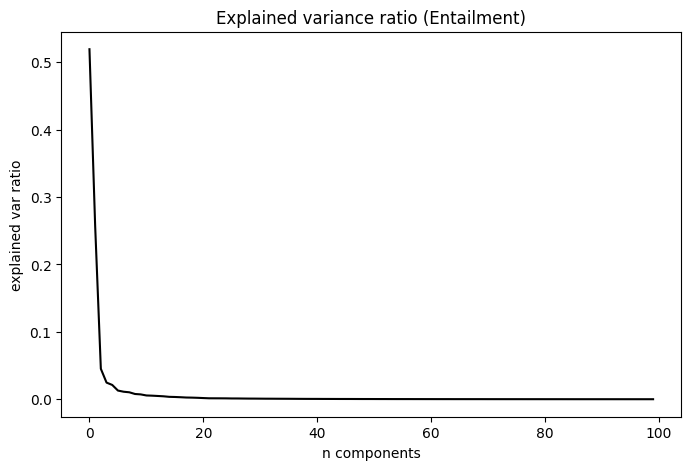

In [8]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
evr = epca_mod.explained_variance_ratio_
ax.plot(np.arange(evr.shape[0]), evr, 'k-')
ax.set_title("Explained variance ratio (Entailment)")
ax.set_xlabel("n components")
ax.set_ylabel("explained var ratio")
plt.show()

In [9]:
spca_mod = PCA(n_components=100)
spca_ = spca_mod.fit_transform(semantic_embeddings)
spca_mod.explained_variance_.shape

(100,)

In [10]:
np.sum(spca_mod.explained_variance_ratio_), np.sum(spca_mod.explained_variance_ratio_[:2])

(np.float32(0.958956), np.float32(0.25671393))

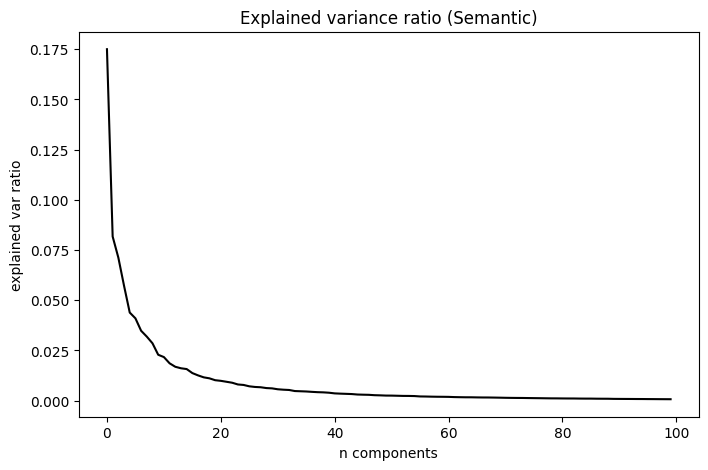

In [11]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
evr = spca_mod.explained_variance_ratio_
ax.plot(np.arange(evr.shape[0]), evr, 'k-')
ax.set_title("Explained variance ratio (Semantic)")
ax.set_xlabel("n components")
ax.set_ylabel("explained var ratio")
plt.show()

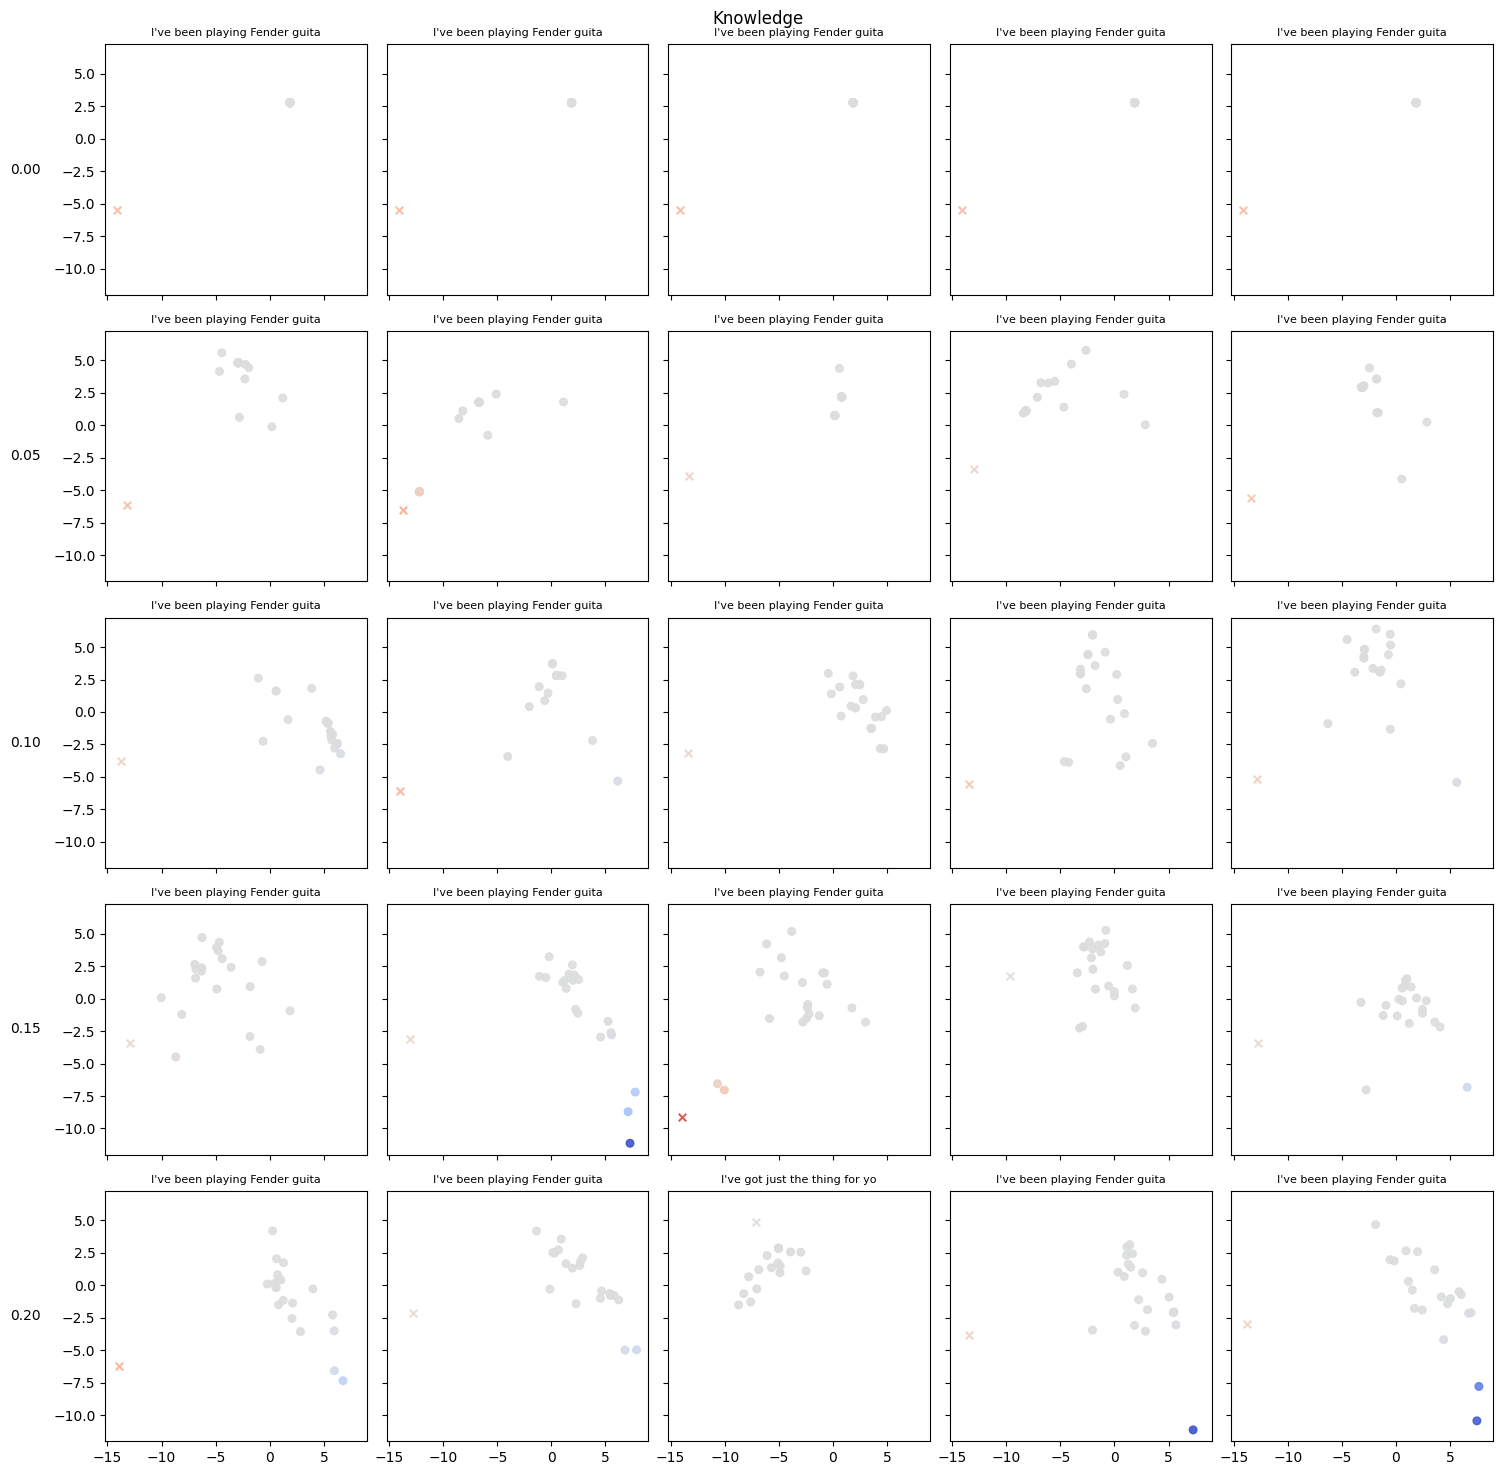

In [12]:
fig, axs = plt.subplots(K, L, figsize=(15,15), sharey=True, sharex=True)

norm = Normalize(vmin=-1, vmax=1)

lever_labels = ["Reason", "Knowledge", "Neutral", "Emotion", "Authority"]

# mr = etsne.reshape(J, K, L, M, -1)
mr = epca.reshape(J, K, L, M, -1)
pr = entail_probs.reshape(J, K, L, M, -1)
ix = np.arange(len(texts)).reshape(J, K, L, M)

lever = 1
for i in range(J):
    for j in range(L):  # agent 1 response
        ax = axs[i,j]

        # agent 1
        ax.scatter(mr[i, lever, j, 0, 0], mr[i, lever, j, 0, 1], 
            s=30, c=pr[i,lever,j,0,0]-pr[i,lever,j,0,2], cmap="coolwarm", norm=norm, marker="x", alpha=0.9)

        # # agent 0
        ax.scatter(mr[i, lever, j, 1:, 0], mr[i, lever, j, 1:, 1], 
            s=30, c=pr[i,lever, j,1:,0]-pr[i, lever,j,1:,2], cmap="coolwarm", norm=norm, marker="o", alpha=0.9)

        # if i==0:
        ax.set_title(texts[ix[i,lever,j,0]][:30], fontsize=8)

    # axs[i,0].set_ylabel(lever_labels[i], rotation=0, labelpad=20, va="center")
    axs[i,0].set_ylabel(temps[i], rotation=0, labelpad=20, va="center")
    # axs[i,0].yaxis.label.set_wrap(True)

fig.suptitle(lever_labels[lever])
plt.tight_layout()
plt.show()

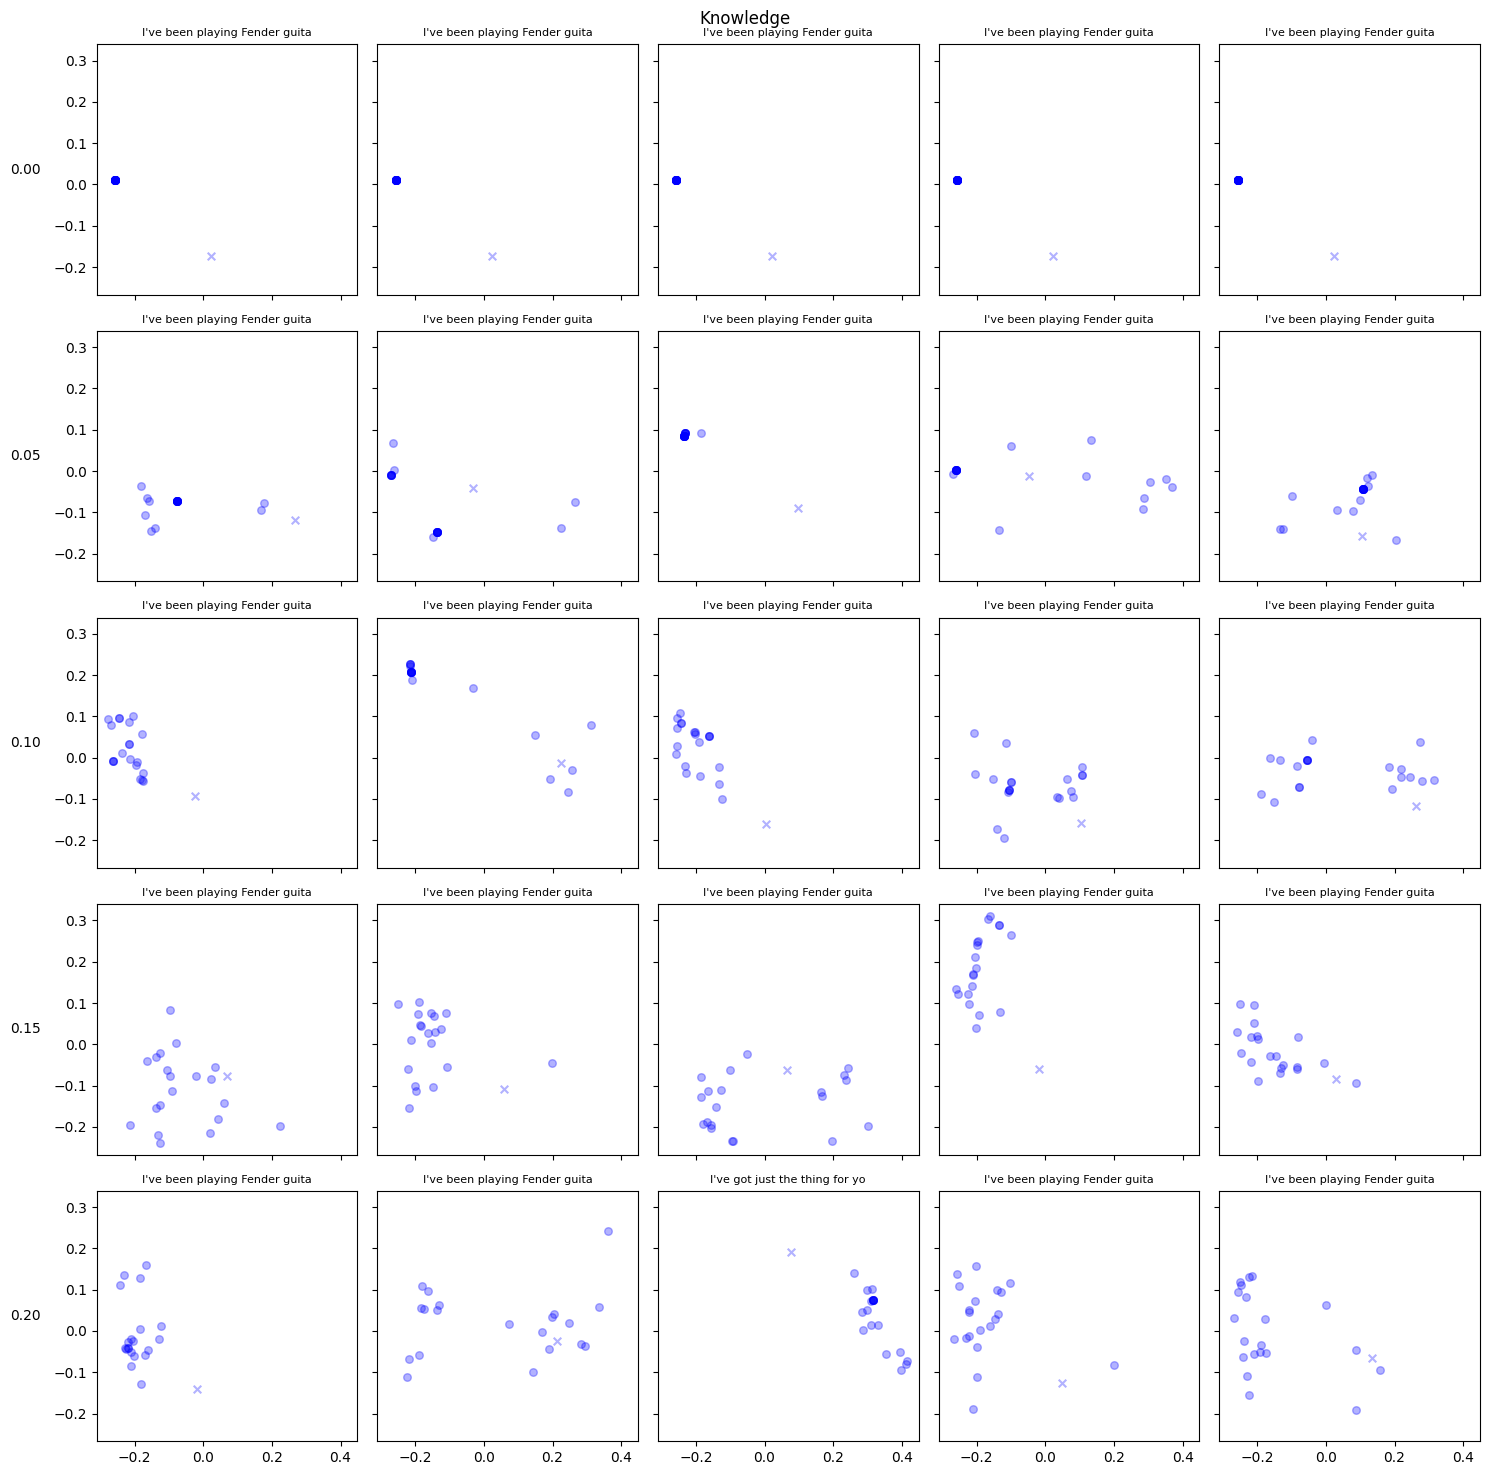

In [14]:
fig, axs = plt.subplots(K, L, figsize=(15,15), sharey=True, sharex=True)

norm = Normalize(vmin=-1, vmax=1)

lever_labels = ["Reason", "Knowledge", "Neutral", "Emotion", "Authority"]

# mr = etsne.reshape(K, L, M, -1)
mr = spca.reshape(J, K, L, M, -1)
# pr = entail_probs.reshape(J, K, L, M, -1)
ix = np.arange(len(texts)).reshape(J, K, L, M)

lever = 1
for i in range(J):
    for j in range(L):  # agent 1 response
        ax = axs[i,j]

        # agent 1
        ax.scatter(mr[i, lever, j, 0, 0], mr[i, lever, j, 0, 1], 
            s=30, c="b", marker="x", alpha=0.3)

        # # agent 0
        ax.scatter(mr[i, lever, j, 1:, 0], mr[i, lever, j, 1:, 1], 
            s=30, c="b", marker="o", alpha=0.3)

        # if i==0:
        ax.set_title(texts[ix[i,lever,j,0]][:30], fontsize=8)

    # axs[i,0].set_ylabel(lever_labels[i], rotation=0, labelpad=20, va="center")
    axs[i,0].set_ylabel(temps[i], rotation=0, labelpad=20, va="center")
    # axs[i,0].yaxis.label.set_wrap(True)

fig.suptitle(lever_labels[lever])
plt.tight_layout()
plt.show()